In [1]:
import os
import sys
from collections import Counter

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import DataLoader, Subset, random_split
from torch.optim.lr_scheduler import StepLR 
from torchinfo import summary
from tqdm.notebook import tqdm

In [2]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
    
print(f"Using {device} device")

Using cpu device


## Data Path Setup

In [3]:
data_dir = "C://Users//DELL//Desktop//Computer_Vision_Projects//tubato_plant_dx//data//external//"
train_dir = os.path.join(data_dir, 'train')

print("Will read data from", train_dir)

Will read data from C://Users//DELL//Desktop//Computer_Vision_Projects//tubato_plant_dx//data//external//train


In [4]:
classes = os.listdir(train_dir)

print("List of classes:", classes)

List of classes: ['cassava_brown_streak', 'cassava_mosaic_disease', 'healthy', 'potato_early_blight', 'potato_late_blight', 'tomato_early_blight', 'tomato_late_blight']


In [5]:
class ConvertToRGB(object):
    def __call__(self, img):
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img

In [6]:
def get_mean_std(loader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in tqdm(loader, desc="Computing mean and std", leave=False):
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches +=1
    mean = channels_sum/num_batches
    std = (channels_squared_sum / num_batches - mean**2)**0.5
    
    return mean, std

In [7]:
transform_normalized = transforms.Compose(
    [
        ConvertToRGB(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=(0.485, 0.456, 0.406),
            std = (0.229, 0.224, 0.225)
            )
   ]
    )

print(type(transform_normalized))
print("-------------")
print(transform_normalized)

<class 'torchvision.transforms.transforms.Compose'>
-------------
Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
)


In [8]:
normalized_dataset = datasets.ImageFolder(root=train_dir, transform=transform_normalized)

print('Length of dataset:', len(normalized_dataset))

Length of dataset: 1358


## Train and Validation Splitting

In [9]:
g = torch.Generator()
g.manual_seed(42)

In [10]:
train_dataset, val_dataset = random_split(normalized_dataset, [0.7, 0.3], generator=g)

print("Length of training dataset:", len(train_dataset))
print("Length of training dataset:", len(val_dataset))

Length of training dataset: 951
Length of training dataset: 407


In [11]:
percent_train = np.round(100*len(train_dataset)/ len(normalized_dataset),2)
percent_val = np.round(100*len(val_dataset) / len(normalized_dataset), 2)


print(f"Train data is {percent_train}% of full data")
print(f"Validation data is {percent_val} of full data")

Train data is 70.03% of full data
Validation data is 29.97 of full data


In [12]:
def class_counts(dataset):
    ds = dataset.dataset if isinstance(dataset, Subset) else dataset
    counts = Counter(lbl for _, lbl in tqdm(dataset, desc="Counting classes"))
    return pd.Series({cls: counts[idx] for cls, idx in ds.class_to_idx.items()})

In [13]:
train_class_distributions = class_counts(train_dataset)
train_class_distributions

Counting classes:   0%|          | 0/951 [00:00<?, ?it/s]

cassava_brown_streak        8
cassava_mosaic_disease     18
healthy                   269
potato_early_blight       132
potato_late_blight        145
tomato_early_blight       134
tomato_late_blight        245
dtype: int64

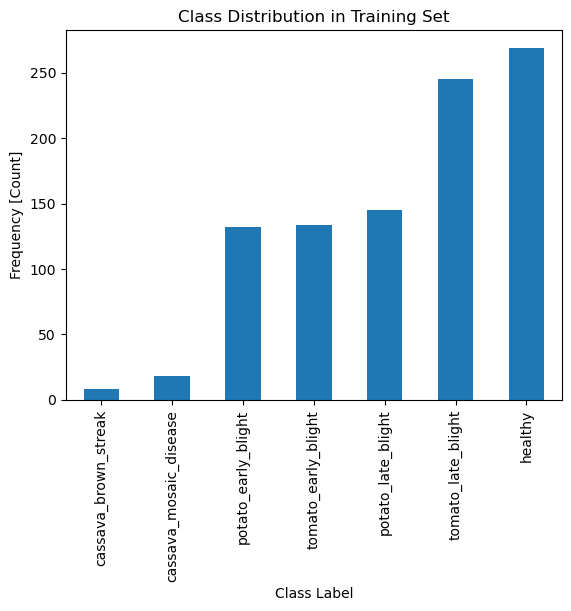

In [14]:
train_class_distributions.sort_values().plot(kind="bar")

plt.xlabel("Class Label")
plt.ylabel("Frequency [Count]")
plt.title("Class Distribution in Training Set");

Counting classes:   0%|          | 0/407 [00:00<?, ?it/s]

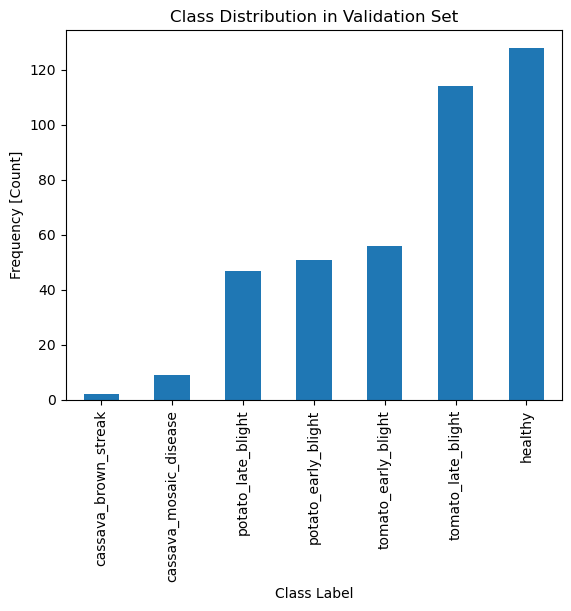

In [15]:
validation_class_distributions = class_counts(val_dataset)

validation_class_distributions.sort_values().plot(kind="bar")

plt.xlabel("Class Label")
plt.ylabel("Frequency [Count]")
plt.title("Class Distribution in Validation Set");

In [16]:
batch_size = 20
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(type(train_loader))
print(type(val_loader))

<class 'torch.utils.data.dataloader.DataLoader'>
<class 'torch.utils.data.dataloader.DataLoader'>


In [17]:
# Load ResNet-18 with pretrained weights
model = resnet18(weights=ResNet18_Weights.DEFAULT)

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
for params in model.parameters():
    params.requires_grad = False
    
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [19]:
in_feat = model.fc.in_features
print(in_feat)

512


In [20]:
out_feat = model.fc.out_features
print(out_feat)

1000


In [21]:
modified_last_layer = nn.Sequential()
modified_last_layer.append(nn.Linear(in_feat, out_feat))

Sequential(
  (0): Linear(in_features=512, out_features=1000, bias=True)
)

In [22]:
relu = nn.ReLU()
modified_last_layer.append(relu)
modified_last_layer.append(nn.Dropout(p=0.5))

Sequential(
  (0): Linear(in_features=512, out_features=1000, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
)

In [23]:
linear =nn.Linear(1000, 7)
modified_last_layer.append(linear)
model.fc = modified_last_layer

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [24]:
loss_fn = nn.CrossEntropyLoss()

In [25]:
optimizer = optim.Adam(model.parameters(), weight_decay = 1e-4)

print(loss_fn)
print("-----------")
print(optimizer)

CrossEntropyLoss()
-----------
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.0001
)


In [26]:
model.to(device)
print(next(model.parameters()).device)

cpu


In [27]:
height=224
width=224

summary(model, input_size = (batch_size, 3, height, width))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [20, 7]                   --
├─Conv2d: 1-1                            [20, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [20, 64, 112, 112]        (128)
├─ReLU: 1-3                              [20, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [20, 64, 56, 56]          --
├─Sequential: 1-5                        [20, 64, 56, 56]          --
│    └─BasicBlock: 2-1                   [20, 64, 56, 56]          --
│    │    └─Conv2d: 3-1                  [20, 64, 56, 56]          (36,864)
│    │    └─BatchNorm2d: 3-2             [20, 64, 56, 56]          (128)
│    │    └─ReLU: 3-3                    [20, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [20, 64, 56, 56]          (36,864)
│    │    └─BatchNorm2d: 3-5             [20, 64, 56, 56]          (128)
│    │    └─ReLU: 3-6                    [20, 64, 56, 56]  

In [28]:
#Period of learning rate decay
step_size = 4
# Multipliative factor of learning rate decay
gamma = 0.2

# Initialize the learning rate scheduler
scheduler = StepLR(
    optimizer,
    step_size = step_size,
    gamma = gamma,
)

print(type(scheduler))

<class 'torch.optim.lr_scheduler.StepLR'>


In [29]:
def early_stopping(validation_loss, best_val_loss, counter):
    
    stop = False
    if validation_loss < best_val_loss:
        counter = 0
    else:
        counter += 1
    
    # check if counter is >= patience (5 epoch in our case)
    # set stop variable accordingly
    if counter >= 5:
        stop = True
        
    return counter, stop

In [30]:
def checkpointing(validation_loss, best_val_loss, model, opitimizer, save_path):
    
    if validation_loss < best_val_loss:
        torch.save(
            {
                "model_state_dict":model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "loss": best_val_loss,
            },
            save_path,
        )
        print(f"Checkpoint saved with validation{validation_loss:.4f}")

In [32]:
from training import score, train_epoch

In [37]:
def train(
    model,
    optimizer,
    loss_fn,
    train_loader,
    val_loader,
    epochs=20,
    device="cpu",
    scheduler=None,
    checkpoint_path=None,
    early_stopping=None,  
):
    # Track the model progress over epochs
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    learning_rates = []
    
    # Track best model for checkpointing/early stopping
    best_val_loss = float("inf")
    early_stopping_counter = 0
    stop = False
    
    print("Model evaluation before start of training...")

    # Initial evaluation
    train_loss, train_accuracy = score(model, train_loader, loss_fn, device)
    train_losses.append(train_loss)   
    train_accuracies.append(train_accuracy)

    val_loss, val_accuracy = score(model, val_loader, loss_fn, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    for epoch in range(1, epochs + 1):
        print("\n")
        print(f"Starting epoch {epoch}/{epochs}")
        
        # Train one epoch
        train_epoch(model, optimizer, loss_fn, train_loader, device)

        # Evaluate training results
        train_loss, train_accuracy = score(model, train_loader, loss_fn, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        # Evaluate validation results
        val_loss, val_accuracy = score(model, val_loader, loss_fn, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        # Logging
        print(f"Epoch: {epoch}")
        print(f"Training loss: {train_loss:.4f}")
        print(f"Training accuracy: {train_accuracy*100:.2f}%")
        print(f"Validation loss: {val_loss:.4f}")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        
        # Log learning rate
        lr = optimizer.param_groups[0]["lr"]
        learning_rates.append(lr)
        if scheduler:
            scheduler.step()
            
        # Checkpointing
        if checkpoint_path:
            checkpointing(val_loss, best_val_loss, model, optimizer, checkpoint_path)
            
        # Early Stopping
        if early_stopping:
            early_stopping_counter, stop = early_stopping(
                val_loss, best_val_loss, early_stopping_counter
            )
            if stop:
                print(f"Early stopping triggered after {epoch} epochs")
                break
        
        # Update best validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
                
    return (
        learning_rates,
        train_losses,
        val_losses,
        train_accuracies,
        val_accuracies,
        epoch,
    )


In [ ]:
# Define number of training epochs
epochs_to_train = 20  

# Call training function
learning_rates, train_losses, val_losses, train_accuracies, val_accuracies, last_epoch = train(
    model,
    optimizer,
    loss_fn,       # your loss function
    train_loader,
    val_loader=val_loader,
    epochs=epochs_to_train,       # ✅ training epochs set to 20
    device=device,
    scheduler=scheduler,
    checkpoint_path="model/LR_model.pth",  # optional
    early_stopping=early_stopping,     # optional
)

(
    learning_rates,
    train_losses
)
